<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Imports</h1>

In [1]:
import librosa
import numpy as np

import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (
    Attention,
    Bidirectional,
    Conv2D,
    MaxPooling2D,
    Reshape,
    Dense,
    Dropout,
    Input,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Constants and Global Variables</h1>

In [2]:
audio = pd.read_csv("Collected Datasets/audio.csv")
audio.info()

EMOTIONS = ["happiness", "neutral", "sadness", "anger", "fear"]
MODELS = [layers.LSTM, layers.GRU, layers.SimpleRNN]


scaler = StandardScaler()
encoder = LabelEncoder()
encoder.classes_ = np.array(EMOTIONS)

BATCH_SIZE = 32
EPOCHS = 20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6074 entries, 0 to 6073
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   mfcc     6074 non-null   object
 1   Emotion  6074 non-null   object
dtypes: object(2)
memory usage: 95.0+ KB


<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Cleaning and Preprocessing</h1>

In [3]:
def _mfccStrToArray(mfccStr):
    vals = np.array(list(map(float, mfccStr.split(","))))
    return vals.reshape(13, vals.size // 13)


def _mfccArrayToStr(mfccArr):
    return ",".join(map(str, mfccArr.flatten()))

In [4]:
def scale(data, f="train"):
    if f == "train":
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    return data

In [5]:
def encode(data, f="train"):
    if f == "train":
        data = encoder.fit_transform(data)
    else:
        data = encoder.transform(data)
    return data

In [6]:
def extractMFCC(filePath):
    y, sr = librosa.load(filePath, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccFlat = mfcc.flatten()
    return ",".join(map(str, mfccFlat))

In [7]:
def zeroPadding(data, maxLen=120):
    data["mfcc"] = data["mfcc"].apply(_mfccStrToArray)

    def _padToMaxLen(mfccArr):
        if mfccArr.shape[1] < maxLen:
            pad_width = maxLen - mfccArr.shape[1]
            mfccArr = np.pad(mfccArr, ((0, 0), (0, pad_width)), mode="constant")
        return mfccArr

    data["mfcc"] = data["mfcc"].apply(_padToMaxLen)
    data["mfcc"] = data["mfcc"].apply(_mfccArrayToStr)
    return data

In [8]:
def evaluateModel(yTrue, yPred):
    print(classification_report(yTrue, yPred, target_names=EMOTIONS))

    accuracy = accuracy_score(yTrue, yPred)
    print(f"Accuracy: {accuracy:.4f}")

    precision = precision_score(yTrue, yPred, average="weighted")
    print(f"Precision: {precision:.4f}")

    recall = recall_score(yTrue, yPred, average="weighted")
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(yTrue, yPred, average="weighted")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(yTrue, yPred)
    print(f"Confusion Matrix:\n{cm}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [9]:
def buildModel(shape, modelType):
    print(f"\nBuilding model with {modelType.__name__}")

    model = Sequential()
    model.add(layers.Input(shape=shape))

    model.add(Reshape((shape[0], shape[1], 1)))

    model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Reshape((-1, model.output_shape[-1] * model.output_shape[-2])))

    model.add(Bidirectional(modelType(120, return_sequences=True)))

    def _attention(x):
        attn_layer = Attention()
        attn_output = attn_layer([x, x])
        return tf.reduce_mean(attn_output, axis=1)

    model.add(layers.Lambda(_attention))

    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(EMOTIONS), activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [10]:
def train(model, xTrain, yTrain, xVal, yVal):
    print(f"\nTraining {model.layers[0].__class__.__name__} model...")
    model.fit(
        xTrain,
        yTrain,
        validation_data=(xVal, yVal),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=True,
    )
    predictions = model.predict(xVal)
    predictions = np.argmax(predictions, axis=1)
    trueLabels = np.argmax(yVal, axis=1)
    evaluateModel(trueLabels, predictions)
    return model

In [11]:
def compareAudioModels(xTrain, yTrain, xVal, yVal):
    bestModel = None
    for model in MODELS:
        model = buildModel(xTrain.shape[1:], model)
        model = train(model, xTrain, yTrain, xVal, yVal)

        if model.layers[0].__class__.__name__ == "SimpleRNN":
            bestModel = model

    return bestModel


Building model with LSTM


Training Reshape model...
Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.3551 - loss: 1.4328 - val_accuracy: 0.4708 - val_loss: 1.2297
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5070 - loss: 1.1885 - val_accuracy: 0.5202 - val_loss: 1.1274
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.5378 - loss: 1.1333 - val_accuracy: 0.5333 - val_loss: 1.1322
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5568 - loss: 1.0942 - val_accuracy: 0.5605 - val_loss: 1.0833
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5711 - loss: 1.0373 - val_accuracy: 0.5597 - val_loss: 1.0536
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6053 - loss: 0.9715 - val_accuracy: 0.5786 - val_loss: 1.0119
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.6190 - loss: 0.9400 - val_accuracy: 0.5802 - val_loss: 1.0346
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9

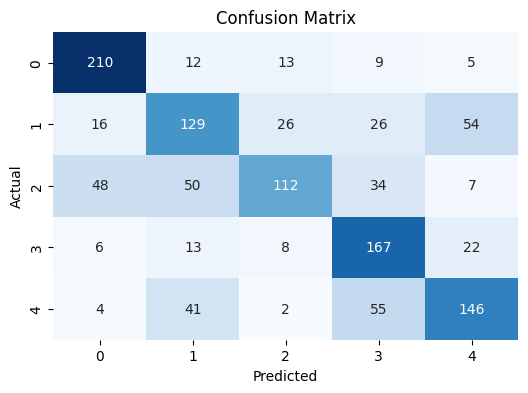


Building model with GRU

Training Reshape model...
Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.3619 - loss: 1.4264 - val_accuracy: 0.4897 - val_loss: 1.2158
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.4803 - loss: 1.2306 - val_accuracy: 0.5350 - val_loss: 1.1252
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5465 - loss: 1.1127 - val_accuracy: 0.5342 - val_loss: 1.1314
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5540 - loss: 1.0812 - val_accuracy: 0.5597 - val_loss: 1.0626
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5748 - loss: 1.0159 - val_accuracy: 0.5547 - val_loss: 1.0738
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6179 - loss: 0.9684 - val_accuracy: 0.5498 - val_loss: 1.0789
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6223 - loss: 0.9485 - val_accuracy: 0.5490 - val_loss: 1.0620
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 5

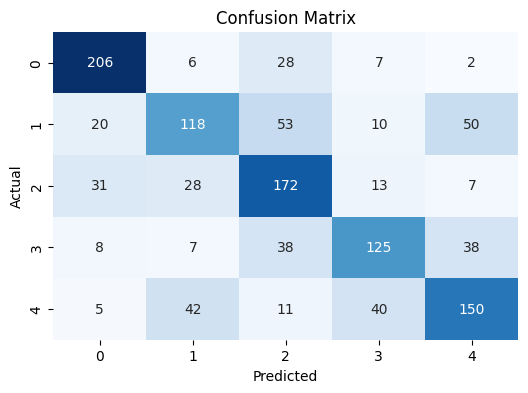


Building model with SimpleRNN

Training Reshape model...
Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.3297 - loss: 1.4817 - val_accuracy: 0.4551 - val_loss: 1.2882
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4520 - loss: 1.2534 - val_accuracy: 0.4749 - val_loss: 1.1931
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4961 - loss: 1.2010 - val_accuracy: 0.4782 - val_loss: 1.1799
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4976 - loss: 1.1763 - val_accuracy: 0.5284 - val_loss: 1.1117
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5299 - loss: 1.1104 - val_accuracy: 0.5432 - val_loss: 1.0884
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5392 - loss: 1.1045 - val_accuracy: 0.5391 - val_loss: 1.1038
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5597 - loss: 1.0630 - val_accuracy: 0.4914 - val_loss: 1.1586
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━

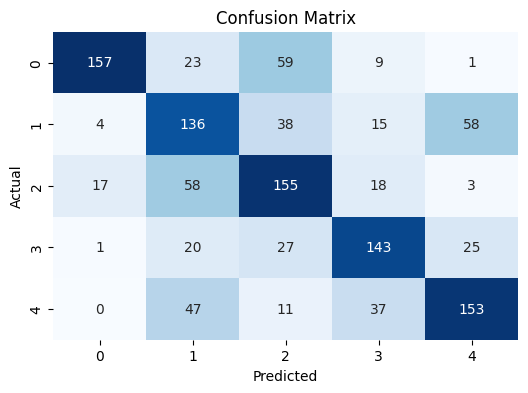

AttributeError: 'NoneType' object has no attribute 'save'

In [ ]:
audio = zeroPadding(audio)

features = np.array([_mfccStrToArray(mfcc) for mfcc in audio["mfcc"]])
features = np.transpose(features, (0, 2, 1))

targets = encode(audio["Emotion"], f="train")
targets = to_categorical(targets)
xTrain, xVal, yTrain, yVal = train_test_split(
    features, targets, test_size=0.2, stratify=targets, random_state=42
)

samplesTrain, timeSteps, numFeatures = xTrain.shape
xTrainFlat = xTrain.reshape(-1, numFeatures)
xValFlat = xVal.reshape(-1, numFeatures)

xTrainScaled = scale(xTrainFlat, f="train")
xValScaled = scale(xValFlat, f="test")

xTrainScaled = xTrainScaled.reshape(samplesTrain, timeSteps, numFeatures)
xValScaled = xValScaled.reshape(xVal.shape[0], timeSteps, numFeatures)

bestModel = compareAudioModels(xTrainScaled, yTrain, xValScaled, yVal)